In [30]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *
import util_moments as yum

yu.setpath('analysis_avgx')

projs=['P0', 'Px', 'Py', 'Pz']
inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
enss=['b','c','d']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path=f'pkl/analysis_c2pt/reg_ignore/ens2pars_jk_meffnst_selected.pkl'
[ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]=yu.load_pkl(path)

# conn

In [3]:
key2tf2ratio={}
for ens in enss:
    key2tf2ratio[(ens,'j+;conn')]={}
    key2tf2ratio[(ens,'j-;conn')]={}
    
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    
    mN_jk=ens2pars_jk_meff2st[ens][:,0]
    factor_equal=1/(-3*mN_jk/4)
    
    path=f'{basepath}/conn_2pt.h5'
    with h5py.File(path) as f:
        moms=yu.moms2list(f['moms'])
        imom=moms.index([0,0,0])
        
        tf2c2pt={}
        for tf in f['data'].keys():
            t=f[f'data/{tf}'][:]
            t=yu.jackknife(np.real(t[:,:,imom]))
            tf2c2pt[int(tf)]=t

    path=f'{basepath}/conn_0,0,0,0,0,0.h5'
    with h5py.File(path) as f:
        moms=yu.moms2list(f['moms'])
        imom=moms.index([0,0,0,0,0,0])
        
        for jtf in f['data'].keys():
            j,tf=jtf.split('_'); tf=int(tf)
            t=f[f'data/{jtf}'][:]
            t=t[:,:,0,projs.index('P0'),inserts.index('tt')]
            c3pt=yu.jackknife(t)
            ratio=np.real(c3pt/tf2c2pt[tf][:,tf:tf+1]*factor_equal[:,None])
            key=(ens,j)
            key2tf2ratio[key][tf]=ratio
            
ens2tfs_conn={}
for ens in enss:
    tfs=list(key2tf2ratio[(ens,'j+;conn')].keys()); tfs.sort()
    ens2tfs_conn[ens]=tfs
    print(ens,tfs)

b [8, 10, 12, 14, 16, 18, 20]
c [6, 8, 10, 12, 14, 16, 18, 20, 22]
d [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]


In [4]:
'''
Symmetrization makes the result slightly different from Christian
'''

key2bare={}

overwrite=False
def createDic(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    # tfmins_1st=get_tfs(0.5,1.2)
    # tcmins_1st=get_tfs(2*lat_a,0.5)
    # tfmins_2st=get_tfs(0.5,0.8)
    # tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tfmins_2st=range(8,ens2tfs_conn[ens][-1],2); tcmins_2st=range(2,ens2tfs_conn[ens][-1]//2-1)
    
    pars_jk_meff2st=ens2pars_jk_meff2st[ens]
    fittype='2st2step_SYMshare'
    
    tf2ratio=key2tf2ratio[(ens,j)]
    fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_sum',overwrite=overwrite)
    fits_2st=yu.doFits_3pt(fittype,tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=pars_jk_meff2st,symmetrizeQ=True,label=f'{ens}_{j}_2st')
    fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=gett(0.2))

    key2bare[(ens,j)]=fit_2st_MA[0][:,0]

    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,None,None,fits_sum,fits_2st],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[None,None,None,fit_2st_MA],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,None,2,None],
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,2,5],
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,2,5],
        'fit_2st_rainbow_midpoint:[fittype,pars_jk_meff2st]':[fittype,ens2pars_jk_meff2st[ens]],
        'xunit':yu.ens2a[ens],
    }
    return dic

js_plt=['j+;conn','j-;conn']; enss_plt=enss

for ij,j in enumerate(js_plt):
    print(f'{ij}/{len(js_plt)}',j,end='                 \r')
    keys=[(ens,j) for ens in enss_plt]

    list_dic=[createDic(key) for key in keys]

    fig,axs=yu.makePlot_3pt(list_dic,shows=['rainbow','midpoint','fit_2st','fit_2st_prob','fit_sum'])
    yu.addRowHeader(axs,[yu.ens2label[ens] for ens in enss_plt])
    yu.finalizePlot(j)
    
yu.save_pkl_reg('key2bare_conn',key2bare)

# disc

In [3]:
ens2c2pt={}; ens2moms_2pt={}; ens2c2pt0={}; ens2Njk={}
for ens in enss:
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    path=f'{basepath}disc_2pt.h5'
    with h5py.File(path) as f:
        moms_2pt=yu.moms2list(f['moms'])
        c2pt=yu.jackknife(np.real(f['data/N_N'][:,:,:]))
        
    ens2moms_2pt[ens]=moms_2pt
    ens2c2pt[ens]=c2pt
    ens2c2pt0[ens]=c2pt[:,:,moms_2pt.index([0,0,0])]
    ens2Njk[ens]=len(c2pt)

key2tf2ratio={}
stouts=[5,7,9,10,11,15,20]
stouts=[0,1,2,3,4]+stouts
js=['j+;disc','js;disc','jc;disc']+[f'jg;stout{stout}' for stout in stouts]
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/05_moments_run5/{yu.ens2full[ens]}/data_merge/disc_0,0,1,0,0,0.h5'
    with h5py.File(path) as f:
        for jtf in f['data'].keys():
            j,tf=jtf.split('_'); tf=int(tf)
            if j not in js:
                continue        
            key=(ens,j)
            if key not in key2tf2ratio:
                key2tf2ratio[key]={}
            c3pt=yu.jackknife(f['data'][jtf][:,:,0,projs.index('P0'),inserts.index('tz')])
            c2pt=ens2c2pt[ens][:,tf,ens2moms_2pt[ens].index([0,0,1])]
            factor=1/(1j*2*np.pi/yu.ens2NL[ens])
            ratio=np.real(c3pt/c2pt[:,None]*factor)
            key2tf2ratio[key][tf]=ratio
            
ens2tfs_disc={}
for ens in enss:
    tfs=list(key2tf2ratio[(ens,'j+;disc')].keys()); tfs.sort()
    ens2tfs_disc[ens]=tfs
    print(ens,tfs[0],tfs[-1])
    
path='pkl/analysis_c2pt/reg_ignore/ens2pars_jk_meffnst_selected.pkl'
[ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]=yu.load_pkl(path)

b 2 22
c 2 26
d 2 30


In [4]:
key2tf2ratio.keys()

dict_keys([('b', 'j+;disc'), ('b', 'jc;disc'), ('b', 'jg;stout0'), ('b', 'jg;stout10'), ('b', 'jg;stout11'), ('b', 'jg;stout15'), ('b', 'jg;stout1'), ('b', 'jg;stout20'), ('b', 'jg;stout2'), ('b', 'jg;stout3'), ('b', 'jg;stout4'), ('b', 'jg;stout5'), ('b', 'jg;stout7'), ('b', 'jg;stout9'), ('b', 'js;disc'), ('c', 'j+;disc'), ('c', 'jc;disc'), ('c', 'jg;stout0'), ('c', 'jg;stout10'), ('c', 'jg;stout11'), ('c', 'jg;stout15'), ('c', 'jg;stout1'), ('c', 'jg;stout20'), ('c', 'jg;stout2'), ('c', 'jg;stout3'), ('c', 'jg;stout4'), ('c', 'jg;stout5'), ('c', 'jg;stout7'), ('c', 'jg;stout9'), ('c', 'js;disc'), ('d', 'j+;disc'), ('d', 'jc;disc'), ('d', 'jg;stout0'), ('d', 'jg;stout10'), ('d', 'jg;stout11'), ('d', 'jg;stout15'), ('d', 'jg;stout1'), ('d', 'jg;stout20'), ('d', 'jg;stout2'), ('d', 'jg;stout3'), ('d', 'jg;stout4'), ('d', 'jg;stout5'), ('d', 'jg;stout7'), ('d', 'jg;stout9'), ('d', 'js;disc')])

In [29]:
def get(ens):
    tf2ratio=key2tf2ratio[(ens,'jg;stout0')]
    tcmins_1st=[2,4,6]
    fits_band=yu.doFits_3pt_band(tf2ratio,tcmins_1st,tfmax=16,corrQ=False)
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,None,None,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,12,2,2],
        'xunit':yu.ens2a[ens]
    }
    return dic

fig,axs=yu.makePlot_3pt([get(ens) for ens in enss],shows=['rainbow','midpoint','fit_band'])
fig.suptitle('stout0')
yu.addRowHeader(axs,[yu.ens2label[ens] for ens in enss])
yu.finalizePlot(closeQ=True)

In [11]:
t=key2tf2ratio[('b','j+;disc')][10]
yu.jackme_un2str(t)
# np.mean(t,axis=0)

'[0.062(26), 0.058(28), 0.034(26), 0.079(26), 0.099(27), 0.087(27), 0.072(28), 0.071(27), 0.128(26), 0.083(28), 0.026(27)]'

In [3]:
print('quark')
for ens in enss:
    tfmin=0.8; tfmax=1.3; tcmin=0.2
    print(ens,'band:tfmin,tfmax,tcmin',round(tfmin/yu.ens2a[ens]),round(tfmax/yu.ens2a[ens]),round(tcmin/yu.ens2a[ens]))
    tfmax=1.5; tfmin_min=0.8; tfmin_max=1.2; tcmin_min=0.2; tcmin_max=0.5
    print(ens,'const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max',round(tfmax/yu.ens2a[ens]),round(tfmin_min/yu.ens2a[ens]),round(tfmin_max/yu.ens2a[ens]),round(tcmin_min/yu.ens2a[ens]),round(tcmin_max/yu.ens2a[ens]))
    
print('gluon')
for ens in enss:
    tfmin=0.8; tfmax=1.3; tcmin=0.2
    print(ens,'band:tfmin,tfmax,tcmin',round(tfmin/yu.ens2a[ens]),round(tfmax/yu.ens2a[ens]),round(tcmin/yu.ens2a[ens]))
    tfmax=1.6; tfmin_min=0.55; tfmin_max=1.5; tcmin_min=0.2; tcmin_max=0.5
    print(ens,'const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max',round(tfmax/yu.ens2a[ens]),round(tfmin_min/yu.ens2a[ens]),round(tfmin_max/yu.ens2a[ens]),round(tcmin_min/yu.ens2a[ens]),round(tcmin_max/yu.ens2a[ens]))


quark
b band:tfmin,tfmax,tcmin 10 16 3
b const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max 19 10 15 3 6
c band:tfmin,tfmax,tcmin 12 19 3
c const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max 22 12 18 3 7
d band:tfmin,tfmax,tcmin 14 23 4
d const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max 26 14 21 4 9
gluon
b band:tfmin,tfmax,tcmin 10 16 3
b const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max 20 7 19 3 6
c band:tfmin,tfmax,tcmin 12 19 3
c const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max 23 8 22 3 7
d band:tfmin,tfmax,tcmin 14 23 4
d const:tfmax,tfmin_min,tfmin_max,tcmin_min,tcmin_max 28 10 26 4 9


In [ ]:
selections=['bandfit_WA','const_MA','sum_MA','2st_MA']
selection2key2bare={selection:{} for selection in selections}

overwrite=False
def createDic(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    tfmins_1st=get_tfs(0.5,1.2)
    tcmins_1st=get_tfs(2*lat_a,0.5)
    tfmins_2st=get_tfs(0.5,0.8)
    tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.5))
    fits_band=yu.doFits_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=False)
    fits_const=yu.doFits_3pt('const',tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_const',overwrite=overwrite)
    fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.8),tcmin_min=gett(0.2))
    fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_sum',overwrite=overwrite)
    fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=gett(0.2))
    fits_2st=yu.doFits_3pt('2st2step_SYMshare',tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_2st')
    fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=gett(0.2))
    
    selection2key2bare['bandfit_WA'][key]=fit_band_WA[0][:,0]
    selection2key2bare['const_MA'][key]=fit_const_MA[0][:,0]
    selection2key2bare['sum_MA'][key]=fit_sum_MA[0][:,0]
    selection2key2bare['2st_MA'][key]=fit_2st_MA[0][:,0]
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,fits_const,fits_sum,fits_2st],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,gett(1.2),2,2],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.3),None,None],
        'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'xunit':yu.ens2a[ens],
    }
    return dic

def createDic2(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    tfmins_1st=get_tfs(0.4,1.5)
    tcmins_1st=get_tfs(2*lat_a,0.5)
    tfmins_2st=get_tfs(0.4,1.0)
    tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.6))
    fits_band=yu.doFits_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=False)
    fits_const=yu.doFits_3pt('const',tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_const',overwrite=overwrite)
    fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.55),tcmin_min=gett(0.2))
    fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_sum',overwrite=overwrite)
    fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=gett(0.2))
    fits_2st=yu.doFits_3pt('2st2step_SYMshare',tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_2st')
    fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=gett(0.2))
    
    selection2key2bare['bandfit_WA'][key]=fit_band_WA[0][:,0]
    selection2key2bare['const_MA'][key]=fit_const_MA[0][:,0]
    selection2key2bare['sum_MA'][key]=fit_sum_MA[0][:,0]
    selection2key2bare['2st_MA'][key]=fit_2st_MA[0][:,0]
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,fits_const,fits_sum,fits_2st],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,gett(1.2),2,2],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.3),None,None],
        'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'xunit':yu.ens2a[ens],
    }
    return dic

# js_plt=['j+;disc']; enss_plt=['b','c','d']
# js_plt=['jg;stout10']; enss_plt=['b','c','d']
js_plt=js; enss_plt=enss

for ij,j in enumerate(js_plt):
    print(f'{ij}/{len(js_plt)}',j,end='                 \r')
    keys=[(ens,j) for ens in enss_plt]

    list_dic=[createDic2(key) if key[1].startswith('jg') else createDic(key) for key in keys]

    yu.makePlot_3pt(list_dic)
    yu.finalizePlot(j)

yu.save_pkl_reg('selection2key2bare_disc',selection2key2bare)

In [64]:
tfs=range(2,30)
tf2ratio_CK={}

path='/p/project1/ngff/kummer3/disconnected/Ratios/D96_Disconnected_gluons_WLS_newRenorm_qsq0.0000_offdiagonal.h5'
with h5py.File(path) as f:
    for tf in tfs:
        t=f[f'qsq0.0000/dt{tf:02d}/10/A20/data'][:]
        tf2ratio_CK[tf]=t

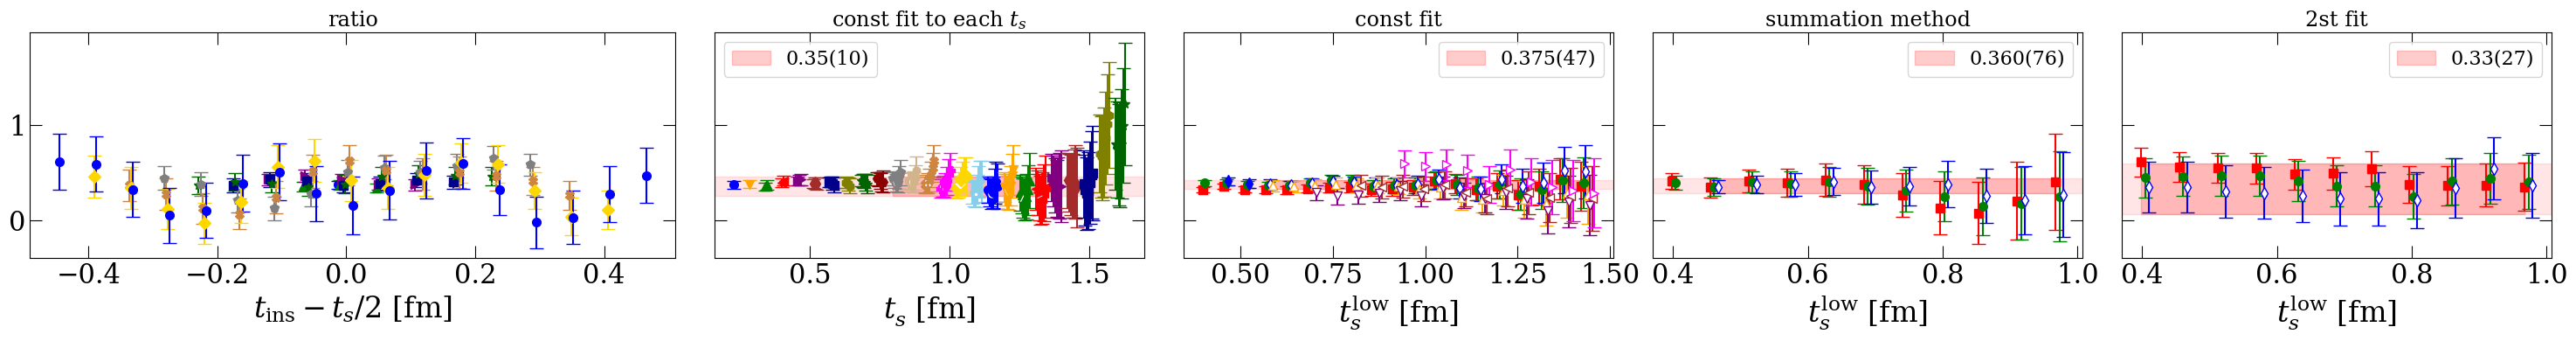

In [69]:
# check
selections=['bandfit_WA','const_MA','sum_MA','2st_MA']
selection2key2bare={selection:{} for selection in selections}

overwrite=False
def createDic(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    tfmins_1st=get_tfs(0.5,1.2)
    tcmins_1st=get_tfs(2*lat_a,0.5)
    tfmins_2st=get_tfs(0.5,0.8)
    tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.5))
    fits_band=yu.doFits_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=False)
    fits_const=yu.doFits_3pt('const',tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_const',overwrite=overwrite)
    fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.8),tcmin_min=gett(0.2))
    fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_sum',overwrite=overwrite)
    fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=gett(0.2))
    fits_2st=yu.doFits_3pt('2st2step_SYMshare',tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_2st')
    fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=gett(0.2))
    
    selection2key2bare['bandfit_WA'][key]=fit_band_WA[0][:,0]
    selection2key2bare['const_MA'][key]=fit_const_MA[0][:,0]
    selection2key2bare['sum_MA'][key]=fit_sum_MA[0][:,0]
    selection2key2bare['2st_MA'][key]=fit_2st_MA[0][:,0]
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,fits_const,fits_sum,fits_2st],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,gett(1.2),2,2],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.3),None,None],
        'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'xunit':yu.ens2a[ens],
    }
    return dic

def createDic2(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    tfmins_1st=get_tfs(0.4,1.5)
    tcmins_1st=get_tfs(2*lat_a,0.5)
    tfmins_2st=get_tfs(0.4,1.0)
    tcmins_2st=get_tfs(2*lat_a,0.3)
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.6))
    # tf2ratio=yu.cut_tf2ratio(tf2ratio_CK,gett(1.6))
    fits_band=yu.doFits_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=gett(0.2),corrQ=False)
    fits_const=yu.doFits_3pt('const',tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_const_noSymmetrization',overwrite=True)
    fit_const_MA=yu.doMA_3pt(fits_const,tfmin_min=gett(0.55),tcmin_min=gett(0.2))
    fits_sum=yu.doFits_3pt('sum',tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_sum',overwrite=overwrite)
    fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=gett(0.2))
    fits_2st=yu.doFits_3pt('2st2step_SYMshare',tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_2st')
    fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=gett(0.2))
    
    selection2key2bare['bandfit_WA'][key]=fit_band_WA[0][:,0]
    selection2key2bare['const_MA'][key]=fit_const_MA[0][:,0]
    selection2key2bare['sum_MA'][key]=fit_sum_MA[0][:,0]
    selection2key2bare['2st_MA'][key]=fit_2st_MA[0][:,0]
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,fits_const,fits_sum,fits_2st],
        'WAMA:[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA]':[fit_band_WA,fit_const_MA,fit_sum_MA,fit_2st_MA],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,gett(1.2),2,2],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.3),None,None],
        'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'xunit':yu.ens2a[ens],
    }
    return dic

# js_plt=['j+;disc']; enss_plt=['b','c','d']
# js_plt=['jg;stout10']; enss_plt=['b','c','d']
js_plt=js; enss_plt=enss
js_plt=['jg;stout10']; enss_plt=['d']

for ij,j in enumerate(js_plt):
    print(f'{ij}/{len(js_plt)}',j,end='                 \r')
    keys=[(ens,j) for ens in enss_plt]

    list_dic=[createDic2(key) if key[1].startswith('jg') else createDic(key) for key in keys]

    yu.makePlot_3pt(list_dic)
    yu.finalizePlot(closeQ=False)

# yu.save_pkl_reg('selection2key2bare_disc',selection2key2bare)

In [9]:
yu.save_pkl('/p/project1/ngff/li47/code/temp/plots_avgx_forChristian/key2tf2ratio.pkl',key2tf2ratio)

# combine

In [3]:
ens2c2pt={}; ens2moms_2pt={}; ens2c2pt0={}; ens2Njk={}
for ens in enss:
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    path=f'{basepath}disc_2pt.h5'
    with h5py.File(path) as f:
        moms_2pt=yu.moms2list(f['moms'])
        c2pt=yu.jackknife(np.real(f['data/N_N'][:,:,:]))
        
    ens2moms_2pt[ens]=moms_2pt
    ens2c2pt[ens]=c2pt
    ens2c2pt0[ens]=c2pt[:,:,moms_2pt.index([0,0,0])]
    ens2Njk[ens]=len(c2pt)

In [4]:
# RCs
ens2Njk={ens:len(ens2c2pt[ens]) for ens in enss}

path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo(ens2RCs_me[ens][key],ens2RCs_me[ens][f'{key}_err']*0+1e-10,ens2Njk[ens])[:,0]
        
path='data_aux/RCs_pre.pkl'
with open(path,'rb') as f:
    ens2RCs_pre_me=pickle.load(f)
ens2RCs_pre={ens:{} for ens in ens2RCs_pre_me.keys()}
for ens in ens2RCs_pre_me.keys():
    for key in ens2RCs_pre_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs_pre[ens][key]=yu.jackknife_pseudo(ens2RCs_pre_me[ens][key],ens2RCs_pre_me[ens][f'{key}_err']+1e-10,ens2Njk[ens])[:,0]

In [5]:
key2bare_conn=yu.load_pkl_reg('key2bare_conn')
selection2key2bare_disc=yu.load_pkl_reg('selection2key2bare_disc')
selections=['bandfit_WA','const_MA','sum_MA','2st_MA']

selection2key2phy={}
selection2key2phy_pre={}
for selection in selections:
    key2bare={**key2bare_conn,**selection2key2bare_disc[selection]}
    yum.extendBare_avgx(key2bare)
    key2phy=yum.bareRC2phy_avgx(key2bare,ens2RCs)
    key2phy_pre=yum.bareRC2phy_avgx_pre(key2bare,ens2RCs,ens2RCs_pre)
    
    selection2key2phy[selection]=key2phy
    selection2key2phy_pre[selection]=key2phy_pre

In [6]:
j2me=yu.load_pkl('pkl/lhapdf/reg_ignore/j2me_NNPDF40_nnlo_as_01180.pkl')
def addexp(ax0,ax1):
    j2color={'jq':'purple','jg':'cyan','jtot':'grey','ju':'r','jd':'g','js':'b','jc':'orange'}
    j2label={'jq':'q','jg':'g','jtot':'N','ju':'u','jd':'d','js':'s','jc':'c'}
    j2fmt={'jq':'d','jg':'s','jtot':'o','ju':'^','jd':'v','js':'<','jc':'>'}
    ax=ax0
    for j in ['jtot','jq','jg']:
        m,e=j2me[j]
        ax.errorbar(0.0002,m,e,color=j2color[j],mfc='white',fmt=j2fmt[j],markersize=4)
    ax=ax1
    for j in ['ju','jd','js','jc']:
        m,e=j2me[j]
        ax.errorbar(0.0002,m,e,color=j2color[j],mfc='white',fmt=j2fmt[j],markersize=4)

In [40]:
figs=[]
stouts_plt=[5,7,9,10,11,15,20]
selections=['bandfit_WA','const_MA','sum_MA','2st_MA']
for stout in stouts_plt:
    list_dic=[
        {'key2phy':yum.convert_key2phy_stout(selection2key2phy[selection],stout),
        'key2phy_pre':yum.convert_key2phy_stout(selection2key2phy_pre[selection],stout)}
        for selection in selections
    ]
    fig,axs=yum.makePlot_a2dependence_avgx(list_dic)
    
    for i in range(len(list_dic)):
        addexp(axs[0,i],axs[1,i])
    
    fig.suptitle(f'stout{stout}')
    yu.addColHeader(axs,selections)
    yu.finalizePlot(closeQ=True)
    figs.append(fig)
        
yu.makePDF('a2dep',figs)

figs=[]
for selection in selections:
    list_dic=[
        {'key2phy':yum.convert_key2phy_stout(selection2key2phy[selection],stout),
        'key2phy_pre':yum.convert_key2phy_stout(selection2key2phy_pre[selection],stout)}
        for stout in stouts_plt
    ]
    fig,axs=yum.makePlot_a2dependence_avgx(list_dic)
    
    for i in range(len(list_dic)):
        addexp(axs[0,i],axs[1,i])
        
    fig.suptitle(selection)
    yu.addColHeader(axs,[f'stout{stout}' for stout in stouts_plt])
    yu.finalizePlot(closeQ=True)
    figs.append(fig)
    
yu.makePDF('a2dep_stout',figs)

In [11]:
selection='const_MA'; stout=10
list_dic=[
    {'key2phy':yum.convert_key2phy_stout(selection2key2phy[selection],stout),
    'key2phy_pre':yum.convert_key2phy_stout(selection2key2phy_pre[selection],stout)}
]
fig,axs=yum.makePlot_a2dependence_avgx(list_dic)
addexp(axs[0,0],axs[1,0])

yu.finalizePlot(f'a2dep_{selection}_stout{stout}')

In [12]:
selection='const_MA'; stout=10
list_dic=[
    {'key2phy':yum.convert_key2phy_stout(selection2key2phy_pre[selection],stout),
    'key2phy_pre':yum.convert_key2phy_stout(selection2key2phy[selection],stout)}
]
fig,axs=yum.makePlot_a2dependence_avgx(list_dic)
addexp(axs[0,0],axs[1,0])

yu.finalizePlot(f'a2dep_{selection}_stout{stout}_pre')

<ErrorbarContainer object of 3 artists>

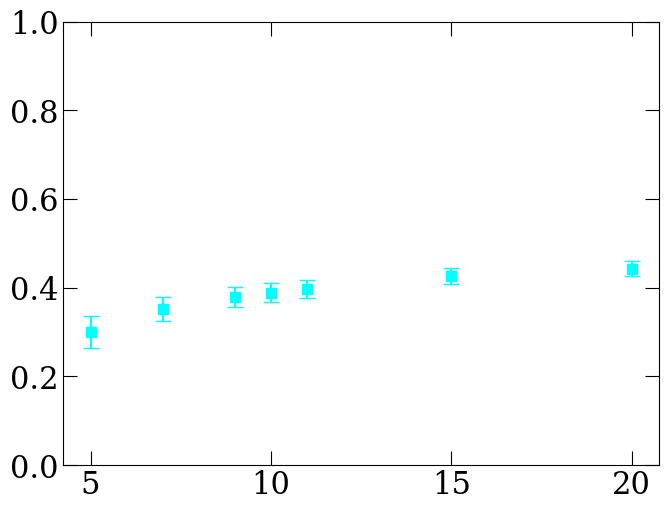

In [12]:
selection2key2bare_disc['const_MA'].keys()

fig,axs=yu.getFigAxs(1,1)
ax=axs[0,0]
ax.set_ylim(0,1)
ens='b'
stouts=[5,7,9,10,11,15,20]

j='jg'
ys=np.transpose([selection2key2bare_disc['const_MA'][(ens,f'{j};stout{stout}')] for stout in stouts])
mean,err=yu.jackme(ys)
ax.errorbar(stouts,mean,err,color='cyan')

['0.64(17)', '0.64(17)', '0.64(17)', '0.64(17)', '0.64(17)', '0.64(17)', '0.64(17)']


<ErrorbarContainer object of 3 artists>

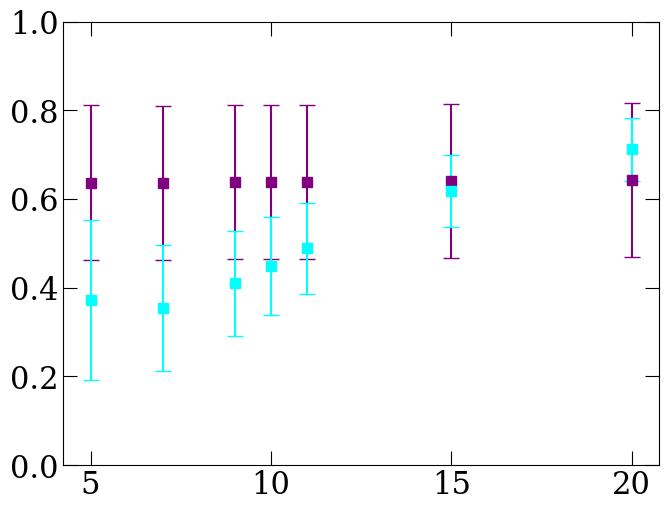

In [7]:
fig,axs=yu.getFigAxs(1,1)
ax=axs[0,0]
ax.set_ylim(0,1)
ens='b'
stouts=[5,7,9,10,11,15,20]

j='jq'
ys=np.transpose([selection2key2phy_pre[selection][(ens,f'{j};stout{stout}')] for stout in stouts])
mean,err=yu.jackme(ys)
print(yu.un2str(mean,err))
ax.errorbar(stouts,mean,err,color='purple')

j='jg'
ys=np.transpose([selection2key2phy_pre[selection][(ens,f'{j};stout{stout}')] for stout in stouts])
mean,err=yu.jackme(ys)
ax.errorbar(stouts,mean,err,color='cyan')


In [12]:
selections=['bandfit_WA','const_MA','sum_MA','2st_MA']
stouts_avg=[9,10,11]
ens='a=#_MA'; js_plt=['jtot','jq','jg','ju','jd','js','jc']
tab=[]
for selection in selections:
    key2phy=selection2key2phy[selection]
    def getj(j):
        y_jk=np.transpose([key2phy[(ens,f'{j};stout{stout}')][:,0] for stout in stouts_avg])
        pars_jk,chi2_jk,Ndof=yu.doFit_const(y_jk)
        return yu.jackme_un2str(pars_jk[:,0])
    
    tab.append([getj(j) for j in js_plt])

df=pd.DataFrame(tab,index=selections,columns=js_plt)
# display(df)
